In [1]:
%matplotlib inline

import numpy as np
from scipy.stats import uniform, expon, lognorm, weibull_min, chi2, wasserstein_distance
from scipy.special import gamma
import matplotlib.pyplot as plt
from sklearn.decomposition import FastICA

In [2]:
rvs = [uniform(), expon(scale=0.1), lognorm(s=1), weibull_min(c=2), chi2(df=4)]

In [3]:
def sample_normed(n, rv):
    return (rv.rvs(size=n) - rv.mean()) / rv.std()

In [4]:
n = 5000
eps = np.zeros((n,len(rvs)))
for i, rv in enumerate(rvs):
    eps[:,i] = sample_normed(n,rv)

In [5]:
# 1-Wasserstein metric between empirical distributions

def wasserstein_dist(X1,X2):
    p1 = X1.shape[1]
    p2 = X2.shape[1]
    D = np.zeros((p1,p2))
    for i in range(p1):
        for j in range(p2):
            D[i,j] = wasserstein_distance(X1[:,i],X2[:,j]) 
    return D

In [6]:
wasserstein_dist(eps,eps)

array([[0.        , 0.37481218, 0.5484035 , 0.16906347, 0.28857013],
       [0.37481218, 0.        , 0.22881496, 0.20853596, 0.08940272],
       [0.5484035 , 0.22881496, 0.        , 0.39461488, 0.27866645],
       [0.16906347, 0.20853596, 0.39461488, 0.        , 0.12460499],
       [0.28857013, 0.08940272, 0.27866645, 0.12460499, 0.        ]])

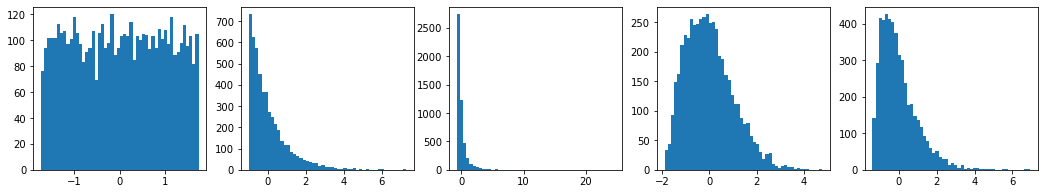

In [205]:
fig, ax = plt.subplots(1, 5, figsize=(18,3))

for j in range(5):
        ax[j].hist(eps[:,j], bins=50)

plt.show()

### Create synthetic observations

In [9]:
nlat = 5
joint_latents = [0,1]
env1_specific = [2]
env2_specific = [3]
env3_specific = [4]
d1 = 10
d2 = 10
d3 = 10

env1_latents = joint_latents + env1_specific
env2_latents = joint_latents + env2_specific
env3_latents = joint_latents + env3_specific

In [10]:
def matrix_from_normal(shape, mu=0, sigma=1):
    A = np.random.normal(loc=mu, scale=sigma, size=shape)
    return A

In [11]:
# Sample entries of G1
np.random.seed(101)
G1 = matrix_from_normal(shape=(d1,len(env1_latents)))
G1

array([[ 2.70684984,  0.62813271,  0.90796945],
       [ 0.50382575,  0.65111795, -0.31931804],
       [-0.84807698,  0.60596535, -2.01816824],
       [ 0.74012206,  0.52881349, -0.58900053],
       [ 0.18869531, -0.75887206, -0.93323722],
       [ 0.95505651,  0.19079432,  1.97875732],
       [ 2.60596728,  0.68350889,  0.30266545],
       [ 1.69372293, -1.70608593, -1.15911942],
       [-0.13484072,  0.39052784,  0.16690464],
       [ 0.18450186,  0.80770591,  0.07295968]])

In [12]:
# G2 and G3
np.random.seed(102)
G2 = matrix_from_normal(shape=(d2,len(env2_latents)))

np.random.seed(103)
G3 = matrix_from_normal(shape=(d3,len(env3_latents)))

In [13]:
# Create synthetic data
X1 =  np.matmul(G1, np.transpose(eps)[env1_latents,:])
X2 =  np.matmul(G2, np.transpose(eps)[env2_latents,:])
X3 =  np.matmul(G3, np.transpose(eps)[env3_latents,:])

In [14]:
env2_latents

[0, 1, 3]

### Apply linear ICA to recover the (empirical) distribution of the sources

In [15]:
def rescale_columns(X):
    for i in range(X.shape[1]):
        X[:,i] = (X[:,i] - X[:,i].mean()) / X[:,i].std()
    return X

# X1 has shape p x n
def get_sources(X, seed=101):
    cov = np.cov(X)
    rk = np.linalg.matrix_rank(cov)
    print("Rank:", rk)
    
    ICA = FastICA(n_components=rk, random_state=seed, whiten='unit-variance', max_iter=1000) 
    ICA.fit(np.transpose(X))
    print("Iterations:", ICA.n_iter_)
    eps = ICA.transform(np.transpose(X))
    scaling = eps.std(axis=0)
    
    eps = rescale_columns(eps)
    mixing = np.matmul(ICA.mixing_, np.diag(scaling))    
    
    return eps, mixing

In [16]:
eps1, mixing1 = get_sources(X1, seed=101)

Rank: 3
Iterations: 5


In [17]:
mixing1

array([[-2.686033  ,  0.91756252, -0.60483185],
       [-0.51721032, -0.32189491, -0.66136035],
       [ 0.79719259, -2.04826756, -0.64071549],
       [-0.75538092, -0.59978692, -0.53501842],
       [-0.19319752, -0.96155407,  0.77281416],
       [-0.91667315,  2.01587942, -0.17269777],
       [-2.59767577,  0.3009987 , -0.66599436],
       [-1.68007019, -1.21086735,  1.75774962],
       [ 0.13119064,  0.17525964, -0.39988845],
       [-0.1947062 ,  0.08195649, -0.82305703]])

In [18]:
eps2, mixing2 = get_sources(X2, seed=102)

Rank: 3
Iterations: 7


In [20]:
eps3, mixing3 = get_sources(X3, seed=103)

Rank: 3
Iterations: 4


In [226]:
indep_comps = [eps1, eps2, eps3]
mixings = [mixing1, mixing2, mixing3]

### Plot recovered distributions

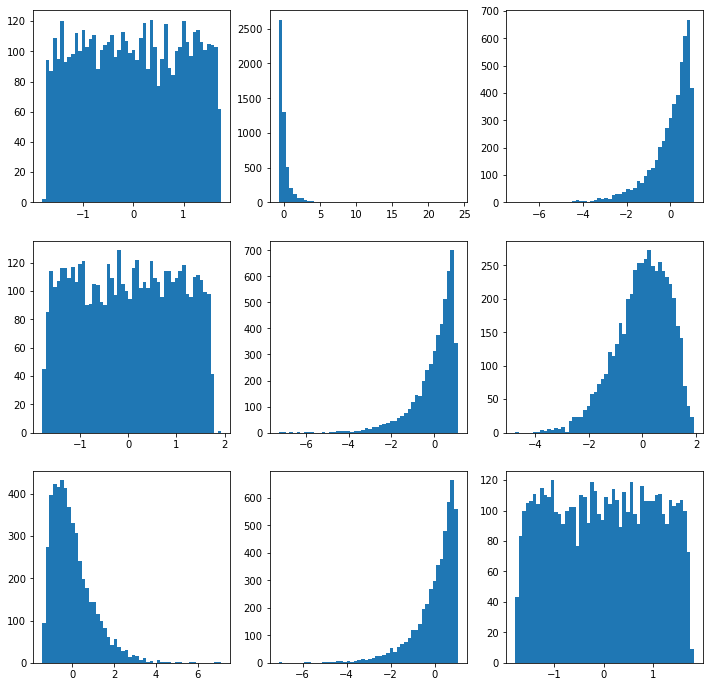

In [196]:
fig, ax = plt.subplots(3, 3, figsize=(12, 12))

for i in range(3):
    for j in range(3):
        ax[i,j].hist(indep_comps[i][:,j], bins=50)

plt.show()

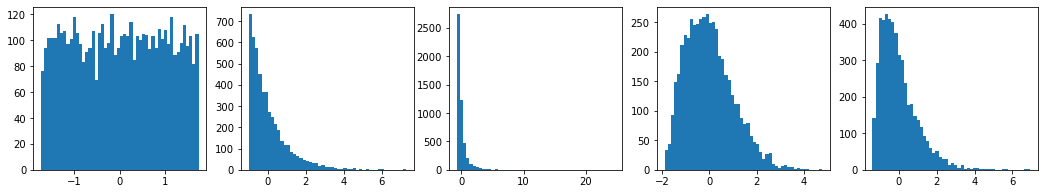

In [204]:
# Compare with "true" distributions

fig, ax = plt.subplots(1, 5, figsize=(18,3))

for j in range(5):
        ax[j].hist(eps[:,j], bins=50)

plt.show()

### Matching

In [24]:
def wasserstein_dist_signed(X1,X2):
    p1 = X1.shape[1]
    p2 = X2.shape[1]
    D_large = np.zeros((p1,2*p2))
    X2_large = np.concatenate((X2,-X2),axis=1)
    for i in range(p1):
        for j in range(2*p2):
            D_large[i,j] = wasserstein_distance(X1[:,i],X2_large[:,j]) 
    D = np.zeros((p1,p2))
    for i in range(p2):
        D[:,i] = D_large[:,[i,i+p2]].min(axis=1)
    return D

In [26]:
def minimum_matching(D):
    p1, p2 = D.shape
    matching = {}
    for i in range(p1):
        row_argmin = D[i,:].argmin()
        if D[:,row_argmin].argmin() == i:
            matching[i] = row_argmin
    return matching

In [208]:
D12 = wasserstein_dist_signed(eps1,eps2)
D12.round(3)

array([[0.003, 0.379, 0.168],
       [0.549, 0.224, 0.398],
       [0.38 , 0.005, 0.219]])

In [28]:
D13 = wasserstein_dist_signed(eps1,eps3)
D13.round(3)

array([[0.279, 0.38 , 0.003],
       [0.298, 0.224, 0.55 ],
       [0.102, 0.002, 0.38 ]])

In [29]:
minimum_matching(D13)

{0: 2, 2: 1}

In [30]:
D23 = wasserstein_dist_signed(eps2,eps3)
D23.round(3)

array([[0.278, 0.379, 0.004],
       [0.101, 0.005, 0.379],
       [0.117, 0.218, 0.168]])

In [31]:
minimum_matching(D23)

{0: 2, 1: 1}

In [274]:
# Definition of a joint factor:
# A collection of distributions of size |E| such that 
# - all distibutions within that joint factor match

In [206]:
def is_consistent(f, matchings):
    for i in range(len(f)):
        for j in range(i+1, len(f)):
            if f[i] not in list(matchings[str(i)+str(j)].keys()):
                return False
            if matchings[str(i)+str(j)][f[i]] != f[j]:
                return False
    return True



def get_joint_factors(indep_comps):
    
    nr_env = len(indep_comps)
    
    matchings = {}
    for i in range(nr_env):
        for j in range(i+1, nr_env):
            D = wasserstein_dist_signed(indep_comps[i],indep_comps[j])
            matchings[str(i)+str(j)] = minimum_matching(D)
    
    # Define potential factors
    pot_factors = [[i] for i in list(matchings['01'].keys())] 
    for f in pot_factors:
        for i in range(1,nr_env):
            if f[0] not in list(matchings['0'+str(i)].keys()):
                continue
            else:
                f.append(matchings['0'+str(i)][f[0]])
    pot_factors = [f for f in pot_factors if len(f)==nr_env]
    
    # Only keep consistent factors
    factors = [f for f in pot_factors if is_consistent(f, matchings)]
    
    return(factors)

In [207]:
joint_factors = get_joint_factors(indep_comps)
joint_factors

# Interpretation:
# We match the following recovered components:
# component 0 of domain 1 WITH component 0 of domain 2 WITH component 2 of domain 3

[[0, 0, 2], [2, 1, 1]]

### Recover joint mixing matrix

In [217]:
def matching_sign(distr1, distr2):
        normal_dist = wasserstein_distance(distr1,distr2) 
        flipped_dist = wasserstein_distance(distr1,distr2)
        if normal_dist <= flipped_dist:
            return 1
        else:
            return -1 

In [221]:
def add_signs_to_factor(f, indep_comps):
    
    signs = [1]
    
    for i in range(1,len(f)):
        signs.append(matching_sign(indep_comps[0][:,f[0]], indep_comps[i][:,f[i]]))
         
    # Check for consistency
    for i in range(1, len(f)):
        for j in range(i+1, len(f)):
            if signs[i]*signs[j] != matching_sign(indep_comps[i][:,f[i]], indep_comps[j][:,f[j]]):
                raise ValueError("Signs are not consistent: ", i, j)
    return signs

In [231]:
joint_factor_signs = [add_signs_to_factor(f, indep_comps) for f in joint_factors]
joint_factor_signs

[[1, 1, 1], [1, 1, 1]]

In [272]:
def joint_mixing_matrix(mixings, joint_factors, joint_factor_signs):
    
    nr_env = len(mixings)
    nr_joint = len(joint_factors)
    total_nr_obs = sum([M.shape[0] for M in mixings])
    total_nr_lat = sum([M.shape[1]-nr_joint for M in mixings]) + nr_joint
    M_large = np.zeros((total_nr_obs, total_nr_lat))
    
    # Joint columns
    for i,f in enumerate(joint_factors):
        current_row = 0
        for env in range(nr_env):
            col = joint_factor_signs[i][env] * mixings[env][:,f[env]]
            M_large[np.ix_(np.arange(current_row,(current_row+len(col))),np.array([i]))] \
            = col.reshape((len(col),1))
            current_row = current_row + len(col)
    
    # Domain-specific columns
    current_col = len(joint_factors)
    current_row = 0
    for env in range(nr_env):
        M = mixings[env]
        nrows, ncols = M.shape
        joint_cols = [f[env] for f in joint_factors]
        domain_spec_cols = set(np.arange(ncols)) - set(joint_cols)
        for i, col in enumerate(domain_spec_cols):
            M_large[np.ix_(np.arange(current_row,(current_row+nrows)),np.array([current_col+i]))] \
            = M[:,col].reshape((nrows,1))
        current_col = current_col + len(domain_spec_cols)
        current_row = current_row + nrows
    return(M_large)

In [273]:
joint_mixing_matrix(mixings, joint_factors, joint_factor_signs)

array([[-2.686033  , -0.60483185,  0.91756252,  0.        ,  0.        ],
       [-0.51721032, -0.66136035, -0.32189491,  0.        ,  0.        ],
       [ 0.79719259, -0.64071549, -2.04826756,  0.        ,  0.        ],
       [-0.75538092, -0.53501842, -0.59978692,  0.        ,  0.        ],
       [-0.19319752,  0.77281416, -0.96155407,  0.        ,  0.        ],
       [-0.91667315, -0.17269777,  2.01587942,  0.        ,  0.        ],
       [-2.59767577, -0.66599436,  0.3009987 ,  0.        ,  0.        ],
       [-1.68007019,  1.75774962, -1.21086735,  0.        ,  0.        ],
       [ 0.13119064, -0.39988845,  0.17525964,  0.        ,  0.        ],
       [-0.1947062 , -0.82305703,  0.08195649,  0.        ,  0.        ],
       [ 1.70317836, -0.97183118,  0.        , -0.96680476,  0.        ],
       [-0.88618819, -1.35416376,  0.        , -0.29470633,  0.        ],
       [-0.52438218,  0.92148164,  0.        ,  0.07181699,  0.        ],
       [-2.21191347, -1.0216213 ,  0. 

Notes: 
Could sample from "empirical joitn distribution" now:
- Have empirical distribution of each independent component (merge the ones for the joint components).
- Sample from the empirical distributions.
- Using the joint mixing matrix, this produces samples of the joint distribution.

Using the joint mixing matrix we can also transport observations in one domain to another.